# GRB 190829A 1D-spectral analysis 

## Reflected BKG MODEL ESTIMATION

### Prerequesties

- To be able to extract the spectral data points, one should undersatand how to extract the spectrum in the Cherenkov Astronomy, especially the OFF background measurements.

- The second one would be also understand the basics of data reduction and how the modelling process in gammapy is done.

### Theoritical context

- In classical Cherenkov Astronomy, spectral analysis which is the simplest where all data inside ON region are binned in 1D-datasets, is used for a specific background estimation technique that uses off measurements taken into the FoV in regions, where the background rate is assumed to be equal to the one in ON region.

- This is useful as it helps to use a specific fit statistics  known as Wstat (`~ gammapy.stats.fit_statistics`). 
- In such case no background model is assumed.
- In this case the background is treated as a set of nuissance parameters and it removes some systematic related to the choice or the quality of the background. 

- On the other hand, this comes with an expense of larger statistical uncertainties on the fitted parameters.

- In this notebook, I aim at performing a full region based spectral analysis of GRB 190829A observations of HESS detected in 2019 (`See H.E.S.S collaboration, 2021 in science Nature`).



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Check package versions
import gammapy
import numpy as np
import astropy
import regions

import warnings
warnings.filterwarnings('ignore')

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

gammapy: 0.17
numpy: 1.18.1
astropy 4.0.3
regions 0.4


In [2]:
work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/grb190829a/"

def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf'] # 'eps'
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_1D/{}/jupyter_notebooks/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)

In [3]:
def get_runlist(run_list):
    cluster1 = [152900, 152901]
    cluster2 = [152902, 152903, 152904]
    cluster3 = [152905, 152906, 152907]

    runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
    runs_hybrid = [152900, 152901, 152902, 152903, 152904, 152905]
    runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
    runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)


    options = ["night1","night2","night3","all","cluster1","cluster2","cluster3"]

    if run_list not in options:
        print("Invalid option,use\n")
        print(options)
        return []

    else:
        if run_list == 'night1':
            runs = runs_night1
        elif run_list == 'night2':
            runs = runs_night2
        elif run_list == 'night3':
            runs = runs_night3
        elif run_list == 'all':
            runs = runs_night1 + runs_night2 + runs_night3
        elif run_list == "cluster1":
            runs = cluster1
        elif run_list == "cluster2":
            runs = cluster2
        elif run_list == "cluster3":
            runs = cluster3
        elif run_list == "hybrid":
            runs = runs_hybrid
        return runs


def load_data(runs):
    # Load FITS data from H.E.S.S database/local cpu
    ds = DataStore.from_dir('$GAMMAPY_DATA/std_ImPACT_fullEnclosure')
    observations = ds.get_observations(runs)

    return observations, ds



In [4]:
def my_residuals(self, method = "diff"):
    fp = self.data
    data = fp.table[fp.sed_type]

    model = self.flux_pred()

    residuals = self._compute_residuals(data, model, method)
    # Remove residuals for upper_limits
    residuals[fp.is_ul] = np.nan

    fp = self.data

    model = self.flux_pred()
    yerr = fp._plot_get_flux_err(fp.sed_type)

    if method == "diff":
        unit = yerr[0].unit
        yerr = yerr[0].to_value(unit), yerr[1].to_value(unit)
    elif method == "diff/model":
        unit = ""
        yerr = (yerr[0] / model).to_value(""), (yerr[1] / model).to_value(unit)
    else:
        raise ValueError("Invalid method, choose between 'diff' and 'diff/model'")

    return residuals, yerr

In [5]:
name_file1 = 'reflectedBg_night2_joint_jupyter'
name_file2 = 'reflectedBg_night2_stacked_jupyter'


print(name_file1 , '\n'+ name_file2)
run_list = 'night2'
# we load the data here:
runs = get_runlist(run_list)

observations, datastore = load_data(runs)

#print(observations)

target_position = SkyCoord(ra=44.544, dec=-8.958, unit="deg", frame="icrs")
on_region_radius = Angle("0.071 deg") # thetasqr= 0.05 deg
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

reflectedBg_night2_joint_jupyter 
reflectedBg_night2_stacked_jupyter


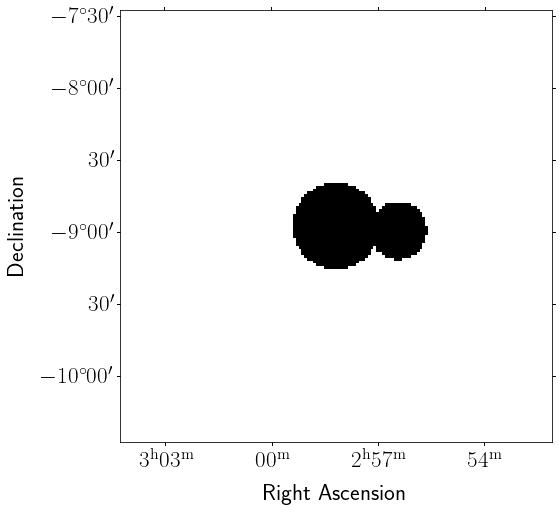

In [6]:
exclusion_region_grb = CircleSkyRegion(
    center=SkyCoord(44.544, -8.958, unit="deg", frame="icrs"),
    radius=0.3 * u.deg,
)

exclusion_region_star = CircleSkyRegion(
    center=SkyCoord(44.106, -8.9891, unit="deg", frame="icrs"),
    radius=0.2 * u.deg,
)
skydir = target_position.icrs
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.02, skydir=skydir, proj="TAN", frame="icrs"
)

mask = exclusion_mask.geom.region_mask([exclusion_region_grb, exclusion_region_star], inside=False)
exclusion_mask.data = mask

fig = plt.figure()
exclusion_mask.plot();
save(fig, "exclusion_mask_reflectedbkg_night2")

In [7]:
e_reco = np.logspace(-1, np.log10(100), 49) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV
#energy_axis = MapAxis.from_edges(np.logspace(-1, 2, 49), unit='TeV', name='energy', interp='log')
dataset_maker = SpectrumDatasetMaker(
containment_correction=True, selection=["counts", "aeff", "edisp"]
)

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)#, binsz="0.05 deg")
safe_mask_masker = SafeMaskMaker(methods=["aeff-default", "edisp-bias"], bias_percent=10)

dataset_empty = SpectrumDataset.create(
e_reco=e_reco, region=on_region
)

In [8]:
%%time
datasets = Datasets()

for obs_id, observation in zip(runs, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 3.31 s, sys: 137 ms, total: 3.45 s
Wall time: 3.52 s


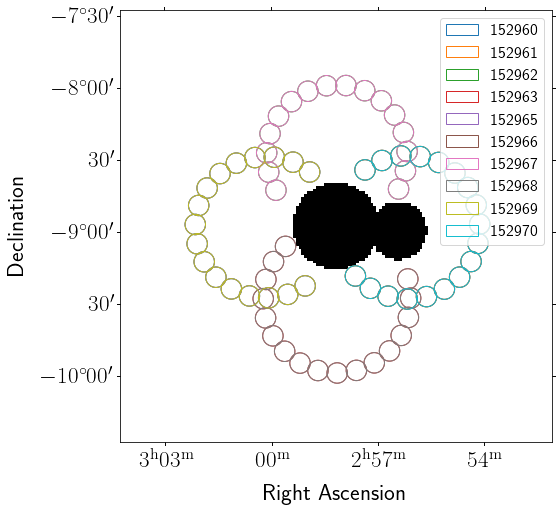

In [9]:
fig = plt.figure()
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
save(fig, "reflected_region_with_exclusion_night2")

In [10]:
info_table = datasets.info_table(cumulative=True)
info_table

<Table length=10>
  name  livetime   n_on  ...  n_off        a_off               alpha        
           s             ...                                                
  str7  float64  float32 ... float32      float64             float64       
------- -------- ------- ... ------- ------------------ --------------------
stacked   1682.0     4.0 ...    46.0               17.0 0.058823529411764705
stacked   3364.0    10.0 ...   100.0 17.525772094726562 0.057058826088905334
stacked   5046.0    14.0 ...   173.0  16.84783172607422  0.05935481935739517
stacked   6727.0    21.0 ...   254.0 16.896060943603516 0.059185393154621124
stacked   8409.0    24.0 ...   312.0 16.915285110473633 0.059118129312992096
stacked  10090.0    36.0 ...   409.0  17.16054344177246  0.05827321112155914
stacked  11771.0    47.0 ...   500.0  16.93695640563965  0.05904248356819153
stacked  13452.0    68.0 ...   615.0  16.94870948791504  0.05900154262781143
stacked  15134.0    75.0 ...   719.0  16.95611000061035 0.058975789695978165
stacked  16430.0    86.0 ...   805.0 17.061817169189453  0.05861040577292442

In [11]:
print('Run   Threshold [TeV]\n')
print('----------------------\n')

# Show energy threshold for each run
min_energy = np.inf
for obs,ds in zip(observations, datasets):
    thres = ds.energy_range[0]
    min_energy = min(min_energy, thres)
    print(obs.obs_id, '{:.4g}'.format(min_energy))

info_table = datasets.info_table(cumulative = True)
print(" Table of source statistics:")
print('------------------------------\n')


#print('--------------------------------------------\n')

print(
'Excess Counts: '+'{:.6s}'.format(str(info_table['excess'][-1])) + '\n', 'On Counts: ' +'{:.6s}'.format( str(info_table['n_on'][-1]))+'\n',
 'Off Counts: '+'{:.6s}'.format(str( info_table['n_off'][-1])) + '\n', 'Livetime: ' + '{:.6s}'.format(str(info_table['livetime'][-1]/3600)) + '\n',
 'Alpha: ' + '{:.6s}'.format(str(info_table['alpha'][-1])) + '\n', 'Background: ' + '{:.6s}'.format(str(info_table['background'][-1])) + '\n',
  'Background_rate: '+ '{:.6s}'.format(str(info_table['background_rate'][-1])) +'\n', 'Excess rate: ' + '{:.6s}'.format(str(info_table['gamma_rate'][-1])) + '\n',
 'Excess/background: ' +'{:.6s}'.format(str(info_table['excess'][-1]/info_table['background'][-1])) + '\n', 'Significance: ' + '{:.6s}'.format(str(info_table['significance'][-1]))
 )

Run   Threshold [TeV]

----------------------

152960 1.155 TeV
152961 0.6494 TeV
152962 0.4217 TeV
152963 0.3162 TeV
152965 0.2738 TeV
152966 0.2371 TeV
152967 0.2054 TeV
152968 0.1778 TeV
152969 0.1778 TeV
152970 0.1778 TeV
 Table of source statistics:
------------------------------

Excess Counts: 38.818
 On Counts: 86.0
 Off Counts: 805.0
 Livetime: 4.5638
 Alpha: 0.0586
 Background: 47.181
 Background_rate: 0.0028
 Excess rate: 0.0023
 Excess/background: 0.8227
 Significance: [4.886


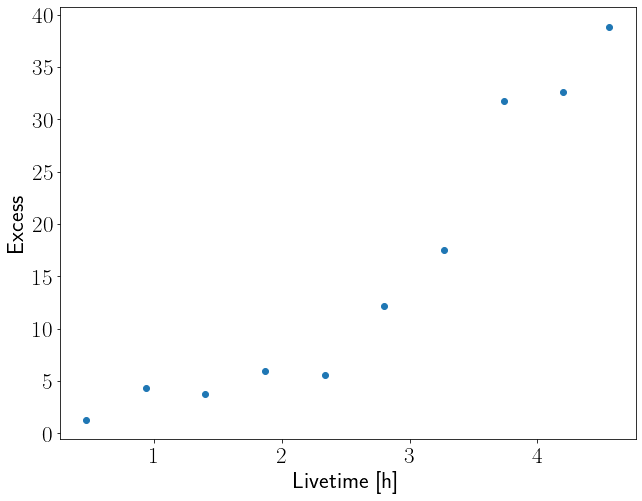

In [12]:
fig = plt.figure()
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

save(fig, "Excess_vs_livetime")

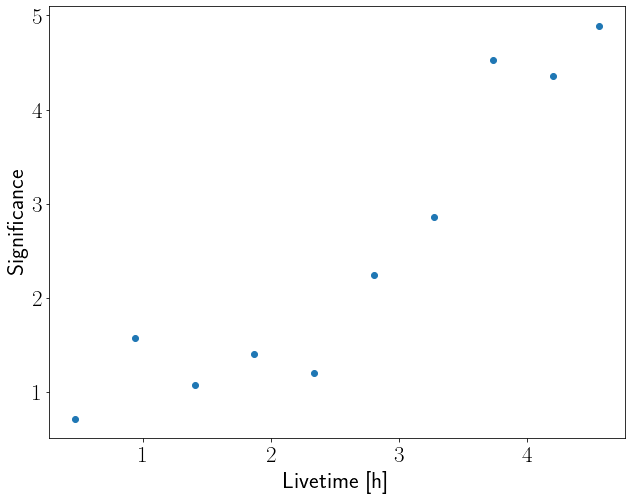

In [13]:
fig = plt.figure()
plt.plot(
    info_table["livetime"].to("h"),
    info_table["significance"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Significance");

save(fig, "Significance_vs_livetime")

152960


<Figure size 1440x1080 with 0 Axes>

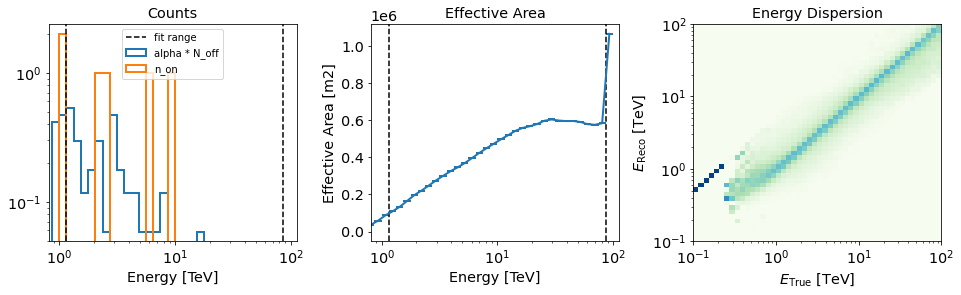

152961


<Figure size 1440x1080 with 0 Axes>

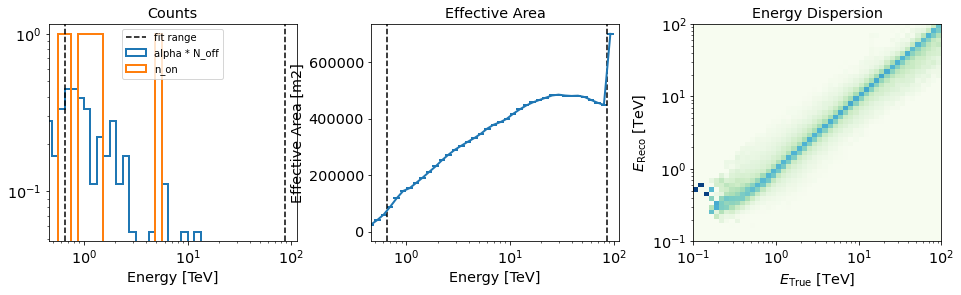

152962


<Figure size 1440x1080 with 0 Axes>

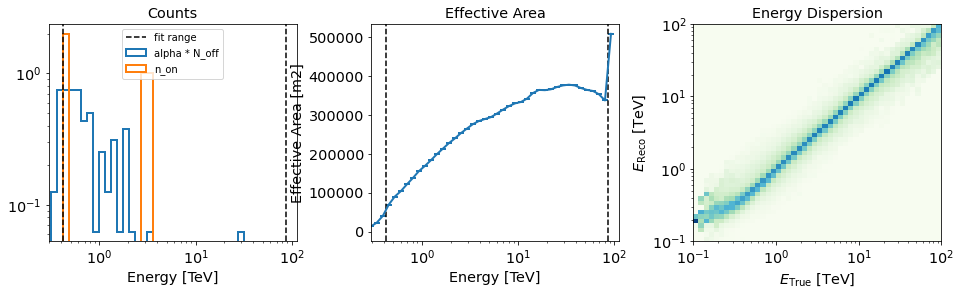

152963


<Figure size 1440x1080 with 0 Axes>

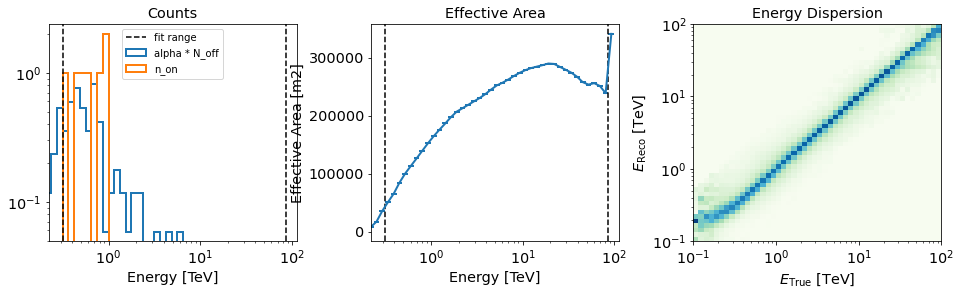

152965


<Figure size 1440x1080 with 0 Axes>

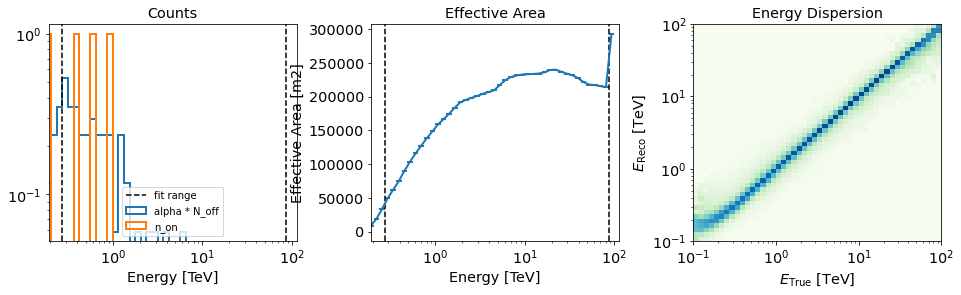

152966


<Figure size 1440x1080 with 0 Axes>

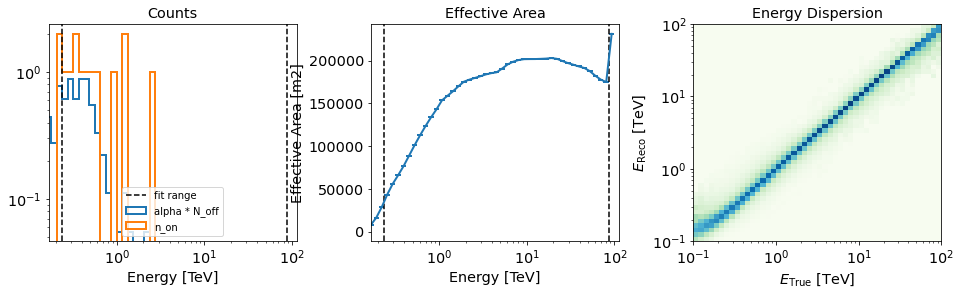

152967


<Figure size 1440x1080 with 0 Axes>

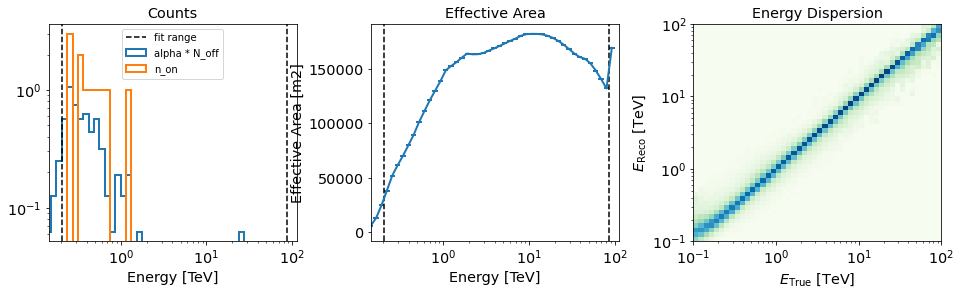

152968


<Figure size 1440x1080 with 0 Axes>

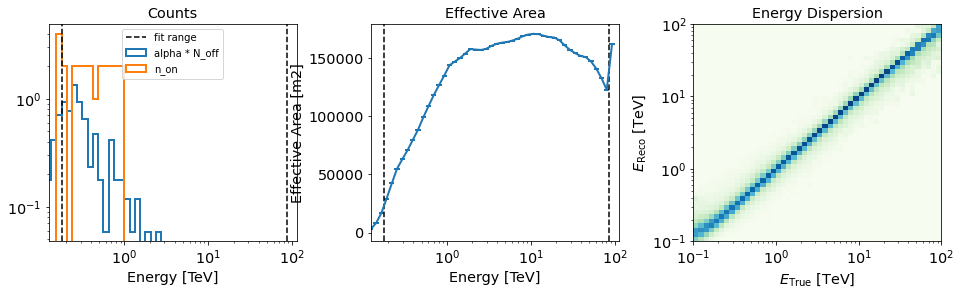

152969


<Figure size 1440x1080 with 0 Axes>

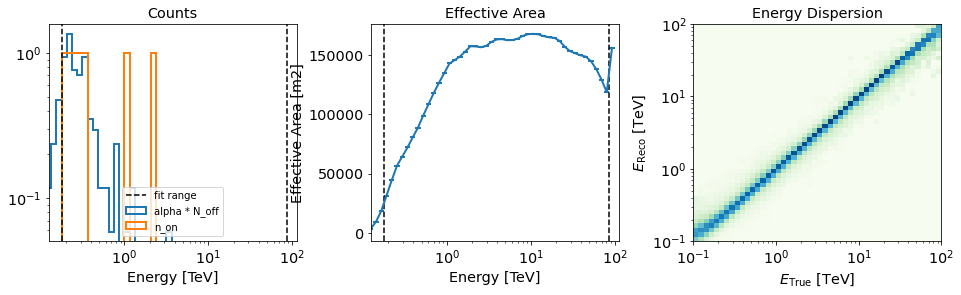

152970


<Figure size 1440x1080 with 0 Axes>

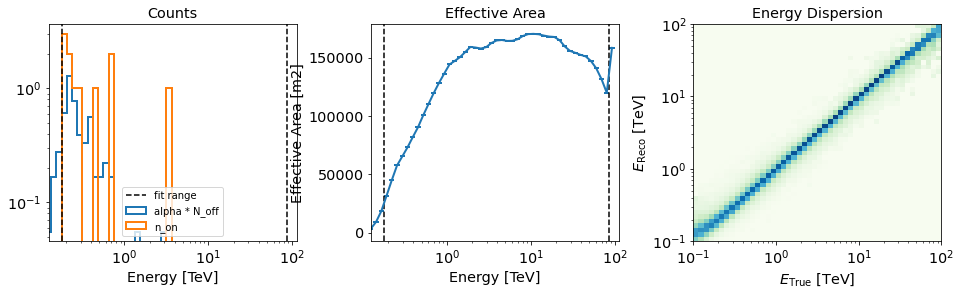

In [14]:
W = 20

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 10,
         'text.usetex': False,
          'font.family': "sans-serif",
          'legend.fontsize': 10,
          }
plt.rcParams.update(params)

for dataset, obs in zip(datasets, observations):
    print(obs.obs_id)
    fig = plt.figure()
    
    d= dataset.peek()
    
    s = plt.show()

In [15]:
path = Path("../Data/1D_spectrum_datasets_night2")
path.mkdir(exist_ok=True)

for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

In [16]:
datasets = Datasets()
for obs_id in runs:
    filename = path / f"pha_obs{obs_id}.fits"
    datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

### Fitting the spectrum

### Joint analysis
- Now we’ll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. 
- If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

In [17]:
spectral_model = PowerLawSpectralModel(
    index=2.0, amplitude=1.0e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=0.556 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="grb")

for dataset in datasets:
    dataset.models = model


In [18]:
%%time
fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()

CPU times: user 2.27 s, sys: 19.5 ms, total: 2.29 s
Wall time: 2.31 s


In [19]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 124
	total stat : 152.31



152960


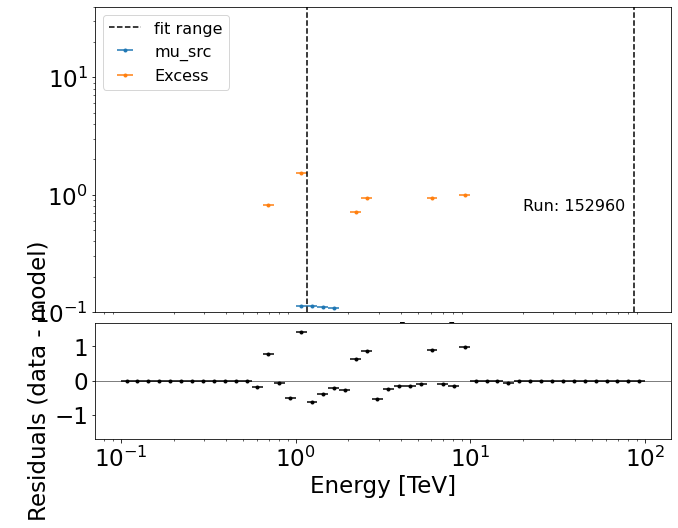

152961


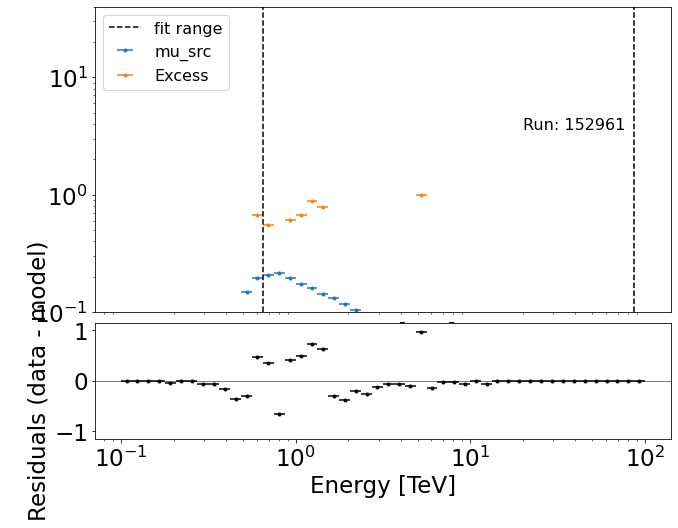

152962


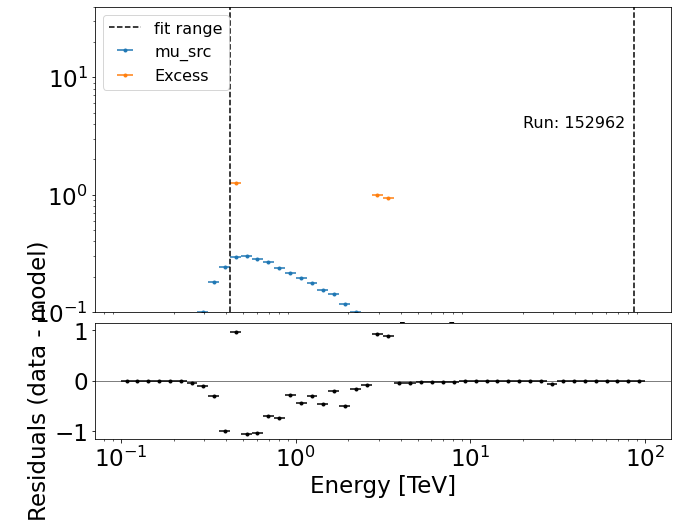

152963


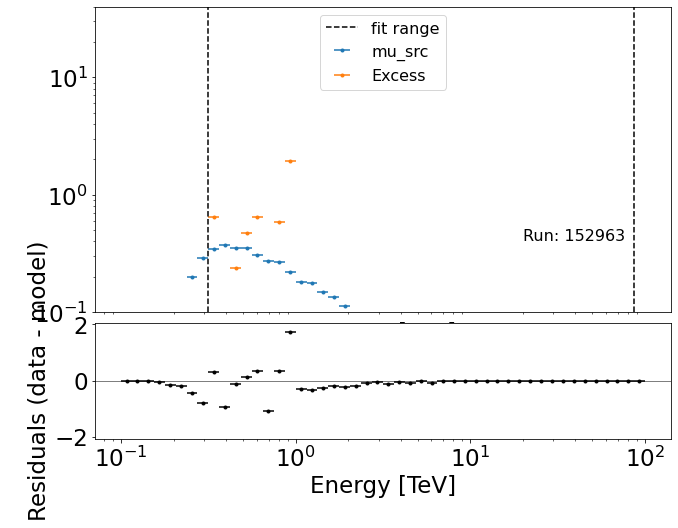

152965


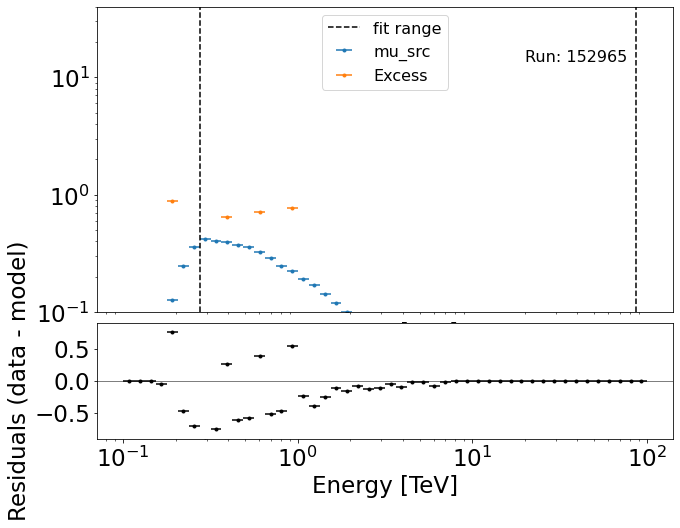

152966


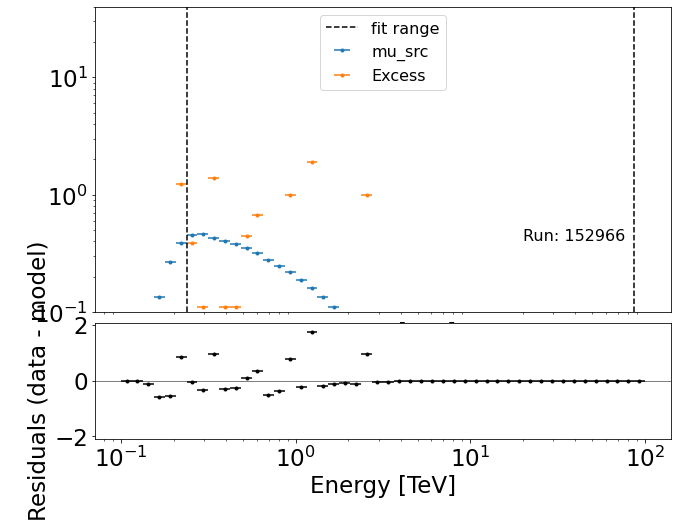

152967


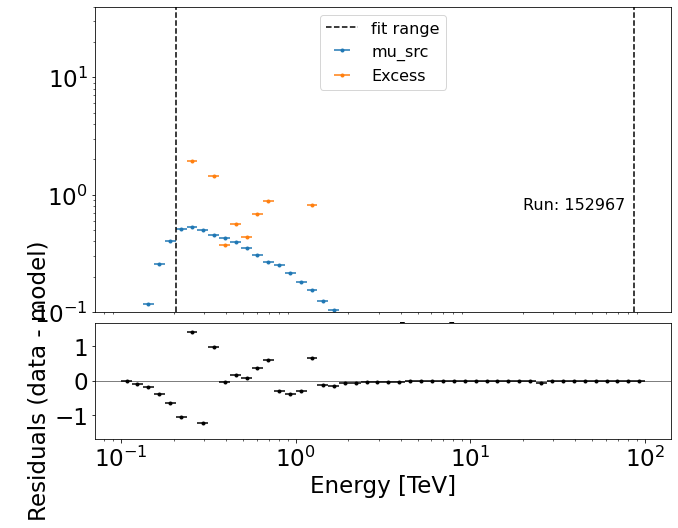

152968


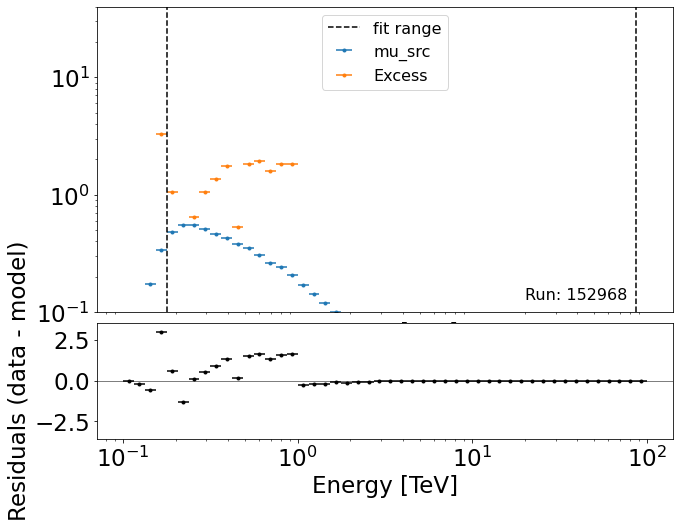

152969


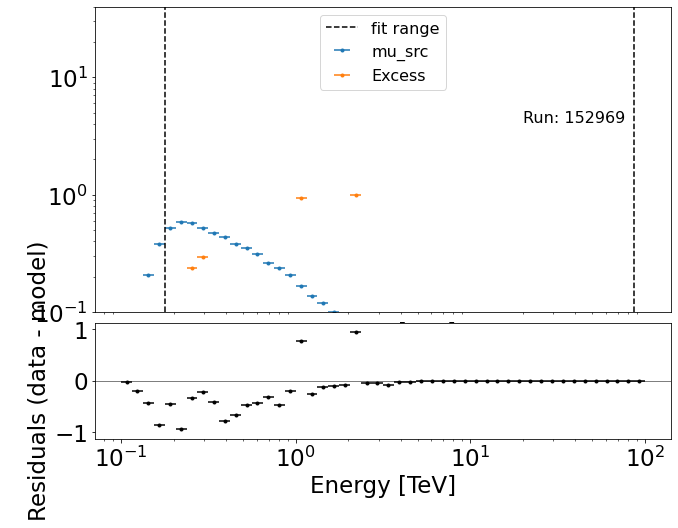

152970


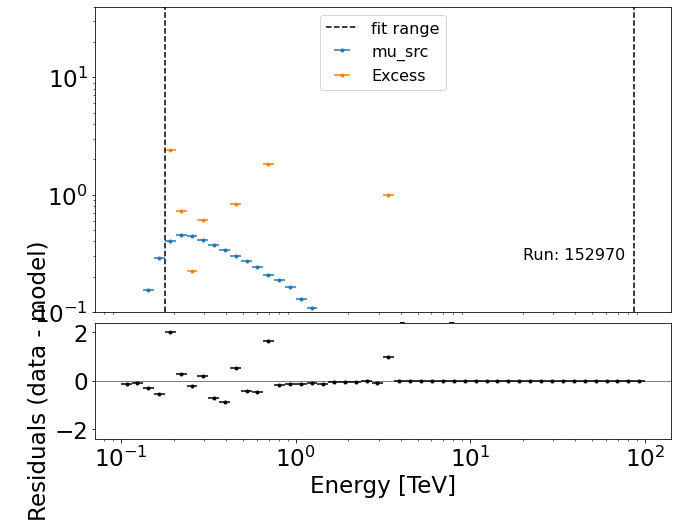

In [20]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': False,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)

for dataset, obs in zip(datasets, observations):
    fig = plt.figure()
    print(obs.obs_id)
    ax_spectrum, ax_residual = dataset.plot_fit()
    ax_spectrum.set_ylim(0.1, 40)
    plt.text(20, 5, f'Run: {obs.obs_id}')
    save(fig, f"spectral_model_joint_{obs.obs_id}")
    
    plt.show()

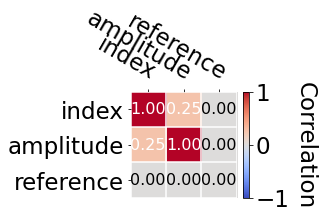

In [21]:
corr_parameters = model_best_joint.covariance.plot_correlation()

In [22]:
model_best_joint.parameters.to_table()

<Table length=3>
   name     value        unit        min     max   frozen   error  
   str9    float64      str14      float64 float64  bool   float64 
--------- --------- -------------- ------- ------- ------ ---------
    index 2.485e+00                    nan     nan  False 2.568e-01
amplitude 2.364e-12 cm-2 s-1 TeV-1     nan     nan  False 5.627e-13
reference 5.560e-01            TeV     nan     nan   True 0.000e+00

### Compute Flux Points

- To round up our analysis we can compute flux points by fitting the norm of the global model in energy bands. We’ll use a fixed energy binning for now:

In [26]:
%%time
ebounds = np.logspace(-0.75, np.log10(2), 6)

ebounds = ebounds[ebounds.searchsorted(min_energy.value+1e-4)-1:]

fpe = FluxPointsEstimator( e_edges = ebounds*u.TeV, reoptimize = True)

with np.errstate(divide='ignore', invalid='ignore'):
    flux_points = fpe.run(datasets=datasets)

CPU times: user 6.66 s, sys: 26.7 ms, total: 6.68 s
Wall time: 6.69 s


In [27]:
flux_points.table_formatted

<Table length=5>
 e_ref   e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
  TeV     TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
float64 float64 float64 ...     float64         float64         float64    
------- ------- ------- ... --------------- --------------- ---------------
  0.221   0.178   0.274 ...       1.620e-11       1.765e-11       1.517e-11
  0.365   0.274   0.487 ...       2.946e-12       3.138e-12       2.751e-12
  0.604   0.487   0.750 ...       1.104e-12       1.160e-12       9.876e-13
  0.931   0.750   1.155 ...       4.171e-13       4.480e-13       3.677e-13
  1.540   1.155   2.054 ...       1.471e-16       6.613e-14       6.447e-20

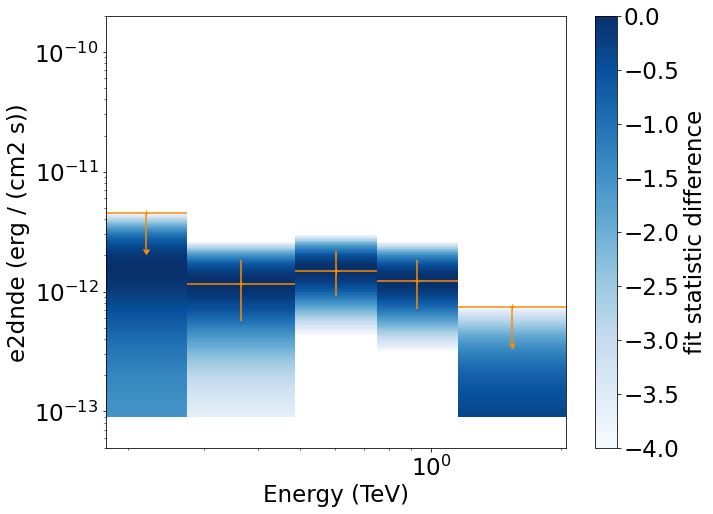

In [28]:
fig = plt.figure()
fp = flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
likelihood = flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
ax.set_ylim(5e-14, 2e-10);

save(fig, name_file1 + "TS_SED_profile")

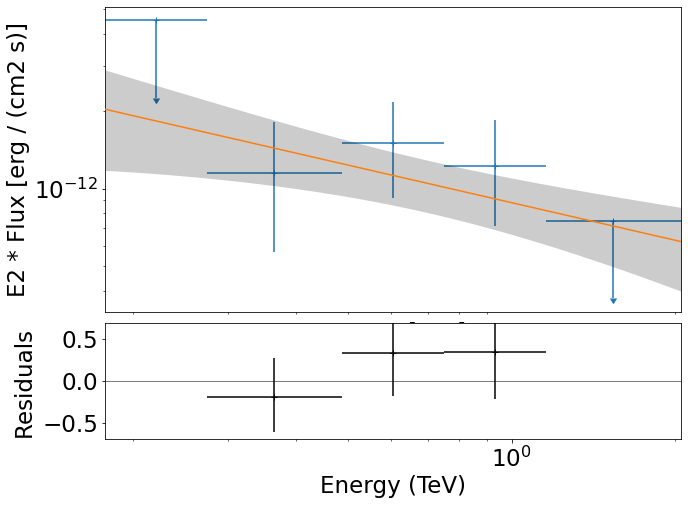

In [29]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

fig = plt.figure()
flux_points_dataset.peek();
save(fig, name_file1 + "flux_point_peek")

In [30]:
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance')
flux    = flux_points.table['dnde'].data
fluxerr = flux_points.table['dnde_err'].data
fluxul  = flux_points.table['dnde_ul'].data
sqrtts  = flux_points.table['sqrt_ts'].data
isul    = sqrtts < 2
for e,f,fl,fh,lim,ul,s in zip(flux_points.table['e_ref'], flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e, f, f-fl, f+fh, s))

Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance
    0.221     |  < 5.773e-11   |                |                |      1.34      
    0.365     |   5.391e-12    |   2.946e-12    |   1.373e-11    |      2.11      
    0.604     |   2.561e-12    |   1.104e-12    |   6.225e-12    |      3.04      
    0.931     |   8.838e-13    |   4.171e-13    |   2.185e-12    |      3.00      
    1.540     |   6.447e-20    |   1.471e-16    |   1.472e-16    |      nan       


In [31]:
flux_points_dataset = FluxPointsDataset(data = flux_points, models = model_best_joint)
flux_points_dataset.residuals = my_residuals
residuals , res_err = flux_points_dataset.residuals(flux_points_dataset, method = "diff/model")
flux_points.table["residuals"] = residuals
flux_points.table["res_errd"] = res_err[0]
flux_points.table["res_erru"] = res_err[1]
#flux_points.table['is_ul'] = flux_points.table['sqrt_ts'] < 2  # set threshold to 2 sigma
flux_points.table_formatted

<Table length=5>
 e_ref   e_min   e_max  ...        res_errd             res_erru     
  TeV     TeV     TeV   ...                                          
float64 float64 float64 ...        float64              float64      
------- ------- ------- ... --------------------- -------------------
  0.221   0.178   0.274 ...    0.6459636637209041  0.7517079713583548
  0.365   0.274   0.487 ...    0.4095078966477033 0.46716354788971604
  0.604   0.487   0.750 ...    0.5138634695755803   0.603422558217389
  0.931   0.750   1.155 ...    0.5592749612623905  0.6813998999463567
  1.540   1.155   2.054 ... 3.427813588530171e-07  0.3515730316765318

In [32]:
flux_points.write('../flux_and_fit_results/night2_1d_flux_points_v17_joint.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts', 'residuals','res_errd','res_erru' ],
                  overwrite=True)


model_best_joint.parameters.to_table().write('../flux_and_fit_results/night2_1d_fit17_joint.csv', overwrite=True)



## Stacked Analysis.

- Another alternative approach is fitting the spectrum is stacking all observations first and the fitting a model.

- For this we first stack the individual datasets:

In [33]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [34]:
%%time
dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

CPU times: user 68.8 ms, sys: 3.54 ms, total: 72.3 ms
Wall time: 70.6 ms


In [35]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 25
	total stat : 27.34



In [36]:
model_best_joint.parameters.to_table()

<Table length=3>
   name     value        unit        min     max   frozen   error  
   str9    float64      str14      float64 float64  bool   float64 
--------- --------- -------------- ------- ------- ------ ---------
    index 2.485e+00                    nan     nan  False 2.568e-01
amplitude 2.364e-12 cm-2 s-1 TeV-1     nan     nan  False 5.627e-13
reference 5.560e-01            TeV     nan     nan   True 0.000e+00

In [37]:
model_best_stacked.parameters.to_table()

<Table length=3>
   name     value        unit        min     max   frozen   error  
   str9    float64      str14      float64 float64  bool   float64 
--------- --------- -------------- ------- ------- ------ ---------
    index 2.492e+00                    nan     nan  False 2.433e-01
amplitude 2.341e-12 cm-2 s-1 TeV-1     nan     nan  False 5.706e-13
reference 5.560e-01            TeV     nan     nan   True 0.000e+00

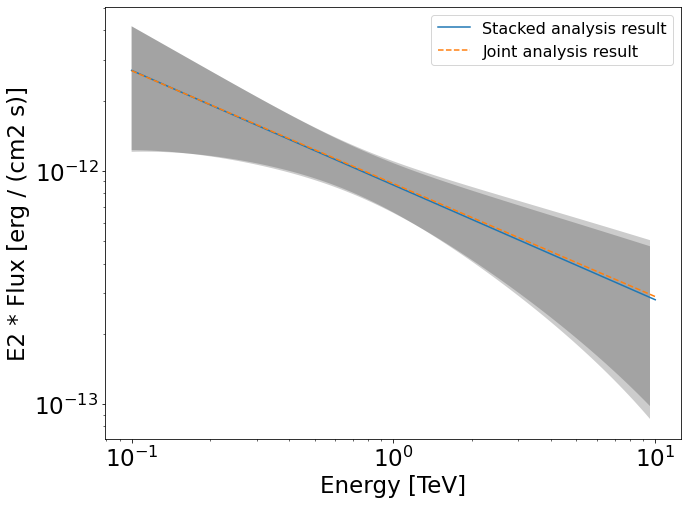

In [38]:
fig = plt.figure()
plot_kwargs = {
    "energy_range": [0.1, 10] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
stacked = model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
error= model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
joint = model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)
l = plt.legend()

save(fig, 'Model_comparison')

In [39]:
%%time
fpe = FluxPointsEstimator( e_edges = ebounds*u.TeV, reoptimize = True)

with np.errstate(divide='ignore', invalid='ignore'):
    flux_points = fpe.run(datasets=dataset_stacked)

CPU times: user 756 ms, sys: 7.06 ms, total: 763 ms
Wall time: 770 ms


In [40]:
flux_points.table_formatted

<Table length=5>
 e_ref   e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
  TeV     TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
float64 float64 float64 ...     float64         float64         float64    
------- ------- ------- ... --------------- --------------- ---------------
  0.221   0.178   0.274 ...       1.647e-11       1.768e-11       1.520e-11
  0.365   0.274   0.487 ...       2.981e-12       3.193e-12       2.814e-12
  0.604   0.487   0.750 ...       1.166e-12       1.175e-12       1.004e-12
  0.931   0.750   1.155 ...       4.520e-13       4.525e-13       3.760e-13
  1.540   1.155   2.054 ...       6.648e-16       8.408e-14       5.671e-19

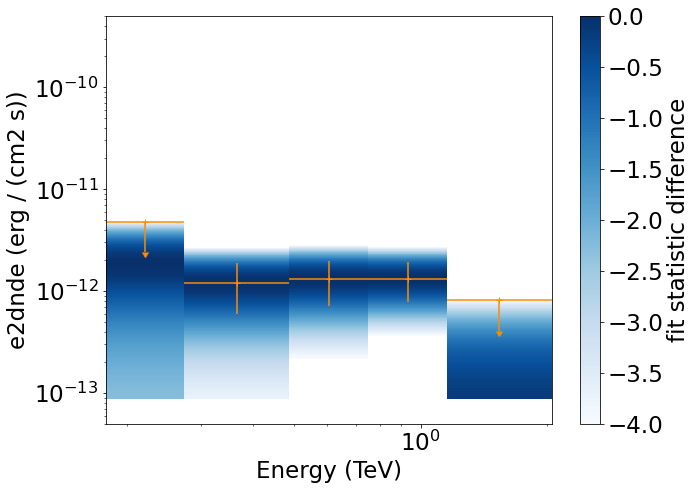

In [41]:
plt.figure()
fp = flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
sedp = flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
ax.set_ylim(5e-14, 5e-10);

save(fig, name_file2 + "TS_SED_profile_stacked")

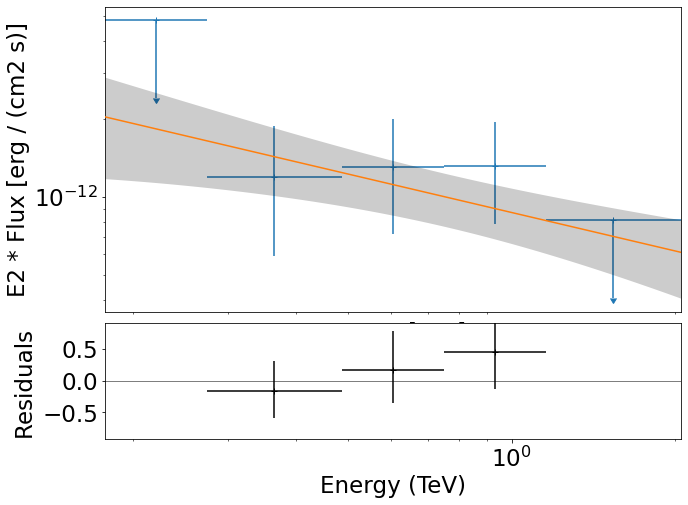

In [42]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_stacked
)

fig = plt.figure()
flux_points_dataset.peek();
save(fig, name_file2 + 'flux_points_peek_stacked')

In [43]:
# Print and save flux point results
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  | E_min [TeV] | E_max [TeV]  |   Flux  |  Flux low | Flux high |  Significance')
E_ref = flux_points.table['e_ref']
E_min = flux_points.table['e_min']
E_max = flux_points.table['e_max']

flux    = flux_points.table['dnde']
fluxerr = flux_points.table['dnde_err']
fluxul  = flux_points.table['dnde_ul']
sqrtts  = flux_points.table['sqrt_ts']
isul    = sqrtts < 2
for e,emin,emax,f,fl,fh,lim,ul,s in zip(E_ref,E_min, E_max, flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^14.3f}|{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e,emin,emax, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^14.3f}|{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e,emin,emax, f, f-fl, f+fh, s))

Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  | E_min [TeV] | E_max [TeV]  |   Flux  |  Flux low | Flux high |  Significance
    0.221     |    0.178     |    0.274     |  < 6.132e-11   |                |                |      1.61      
    0.365     |    0.274     |    0.487     |   5.567e-12    |   2.981e-12    |   1.411e-11    |      2.13      
    0.604     |    0.487     |    0.750     |   2.226e-12    |   1.166e-12    |   5.617e-12    |      2.50      
    0.931     |    0.750     |    1.155     |   9.438e-13    |    4.52e-13    |    2.34e-12    |      3.06      
    1.540     |    1.155     |    2.054     |   5.671e-19    |   6.648e-16    |   6.659e-16    |      nan       


In [44]:
flux_points_dataset = FluxPointsDataset(data = flux_points, models = model_best_stacked)
flux_points_dataset.residuals = my_residuals
residuals , res_err = flux_points_dataset.residuals(flux_points_dataset, method = "diff/model")
flux_points.table["residuals"] = residuals
flux_points.table["res_errd"] = res_err[0]
flux_points.table["res_erru"] = res_err[1]
#flux_points.table['is_ul'] = flux_points.table['sqrt_ts'] < 2  # set threshold to 2 sigma
flux_points.table_formatted

<Table length=5>
 e_ref   e_min   e_max  ...        res_errd              res_erru     
  TeV     TeV     TeV   ...                                           
float64 float64 float64 ...        float64               float64      
------- ------- ------- ... ---------------------- -------------------
  0.221   0.178   0.274 ...     0.6491865748252545  0.7550864070608388
  0.365   0.274   0.487 ...     0.4216800882950319 0.47835500162078076
  0.604   0.487   0.750 ...     0.5280276914103622  0.6175805127134382
  0.931   0.750   1.155 ...     0.5797369451974419  0.6976721274582034
  1.540   1.155   2.054 ... 3.0672409057075356e-06 0.45477485111768773

In [45]:
flux_points.write('../flux_and_fit_results/night2_1d_flux_points_v17_stacked.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts', 'residuals','res_errd','res_erru' ],
                  overwrite=True)


model_best_stacked.parameters.to_table().write('../flux_and_fit_results/night2_1d_fit17_stacked.csv', overwrite=True)



In [46]:
ref_flux = flux_points.table['ref_flux'].data
ref_e = flux_points.table['e_ref'].data
err_min = flux_points.table['e_min'].data
err_max = flux_points.table['e_max'].data
dnde = flux_points.table['dnde'].data
dnde_ref = flux_points.table['ref_dnde'].data
dnde_err = flux_points.table['dnde_err'].data
dnde_low_err = flux_points.table['dnde_errn'].data
dnde_upper_err = flux_points.table['dnde_errp'].data

errlow = ref_e - err_min 
errhigh = err_max - ref_e
xerr = [errlow, errhigh]
yerr = [dnde_err*errlow**2, dnde_err*errhigh**2]

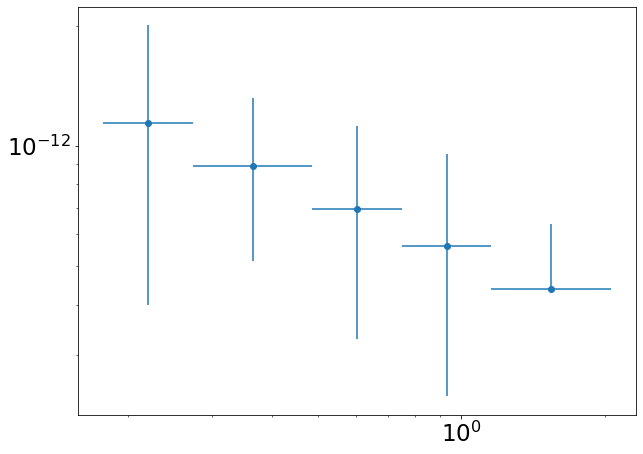

In [47]:
plt.errorbar(ref_e, ref_e**2 * dnde_ref, yerr = ref_e**2 * [dnde_low_err, dnde_upper_err], xerr = xerr, 
            marker = 'o', linestyle= 'none')
plt.xscale('log')
plt.yscale('log')

#### What next?

- The methods shown in this tutorial is valid for point-like or midly extended sources where we can assume that the IRF taken at the region in the center is valid over the whole region. 
- If one wants to extract the 1D spectrum of a large source and properly average the response over the extraction region, one has to use a different approach explained in the `extended source spectral analysis tutorial`.

- The next step will be to work on the code that analyse all nights at once. But I should do all analysis in notebook too.